In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import copy
import scipy.io as sio

## Mean-Smoothing 

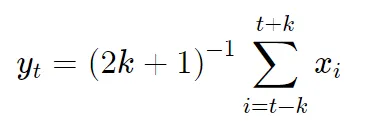

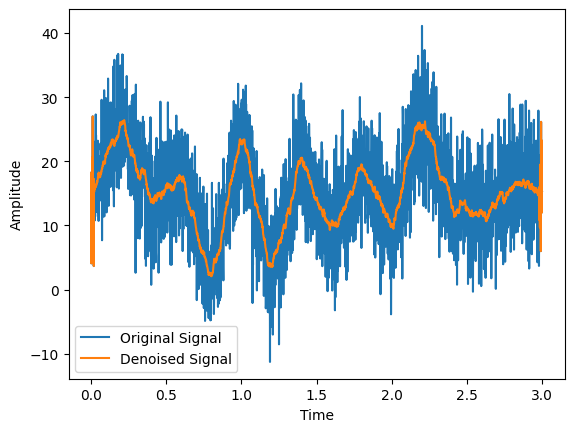

In [2]:
### Create a signal

sRate = 1000  # Number of events in one second (Hz)
time = np.arange(0, 3, 1/sRate)  # Time vector from 0 to 3 seconds with steps of 1/sRate
n = len(time)  # Length of the time vector
p = 15  # Parameter for interpolation

noiseAmp = 5  # Noise level

# Generate amplitude values using linear interpolation of random values
ampl = np.interp(np.linspace(0, p, n), np.arange(0, p), np.random.rand(p) * 30)

# Create Gaussian noise
noise = noiseAmp * np.random.randn(n)

# Combine amplitude and noise to create the signal
signal = ampl + noise

### Applying mean smoothing

# Create a copy of the original signal to store the filtered signal
filterSig = copy.deepcopy(signal)

k = 20  # Window size for smoothing

# Apply mean smoothing over the specified window size
for i in range(k, n - k):
    filterSig[i] = np.mean(signal[i - k:i + k])  # Calculate mean of the surrounding values

# Plotting the original and filtered signals
plt.plot(time, signal, label="Original Signal")  # Plot original signal
plt.plot(time, filterSig, label="Denoised Signal")  # Plot denoised signal
plt.xlabel("Time")  # Label for x-axis
plt.ylabel("Amplitude")  # Label for y-axis
plt.legend()  # Show legend
plt.show()  # Display the plot


## Gaussian-Smoothing

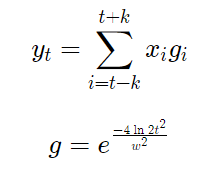

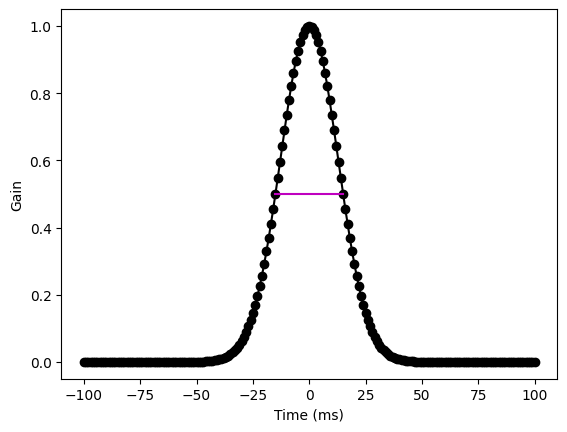

In [3]:
# Define parameters for Gaussian window
w = 30  # Width of the Gaussian window

k = 100  # Half-width of the window in samples
gtime = 1000 * np.arange(-k, k + 1) / sRate  # Time vector for the Gaussian window in milliseconds

# Generate the Gaussian window using the specified width
gausw = np.exp(-(4 * np.log(2) * gtime**2) / w**2)

# Compute empirical Full Width at Half Maximum (FWHM)
# Find the index where the Gaussian reaches half of its maximum value
pstPeakHalf = k + np.argmin((gausw[k:] - 0.5)**2)  # Index for the positive peak half
prePeakHalf = np.argmin((gausw[:k] - 0.5)**2)  # Index for the negative peak half

# Calculate the empirical FWHM
empFWHM = gtime[pstPeakHalf] - gtime[prePeakHalf]  # FWHM calculation

# Show the Gaussian
plt.plot(gtime, gausw, 'ko-')  # Plot Gaussian window
plt.plot([gtime[prePeakHalf], gtime[pstPeakHalf]], 
         [gausw[prePeakHalf], gausw[pstPeakHalf]], 'm')  # Mark FWHM on the plot

# Normalize Gaussian to unit energy
gausw = gausw / np.sum(gausw)  # Normalize the Gaussian window
plt.xlabel('Time (ms)')  # Label for x-axis
plt.ylabel('Gain')  # Label for y-axis

plt.show()  # Display the plot


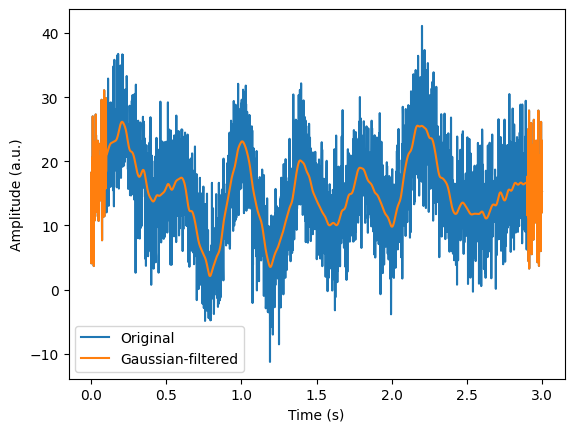

In [4]:
### Applying Gaussian smoothing

# Create a copy of the original signal to store the filtered signal
filterSigG = copy.deepcopy(signal)

# Apply Gaussian filter using the previously defined Gaussian window
for i in range(k + 1, n - k):  # Iterate over the range avoiding the edges
    # Compute the weighted sum of the signal using the Gaussian window
    filterSigG[i] = np.sum(signal[i - k:i + k + 1] * gausw)  

# Plotting the original and Gaussian-filtered signals
plt.plot(time, signal, label='Original')  # Plot original signal
plt.plot(time, filterSigG, label='Gaussian-filtered')  # Plot Gaussian-filtered signal

# Label the axes
plt.xlabel('Time (s)')  # Label for the x-axis
plt.ylabel('Amplitude (a.u.)')  # Label for the y-axis
plt.legend()  # Show legend
plt.show()  # Display the plot

### Gaussian-smooth a spike time series

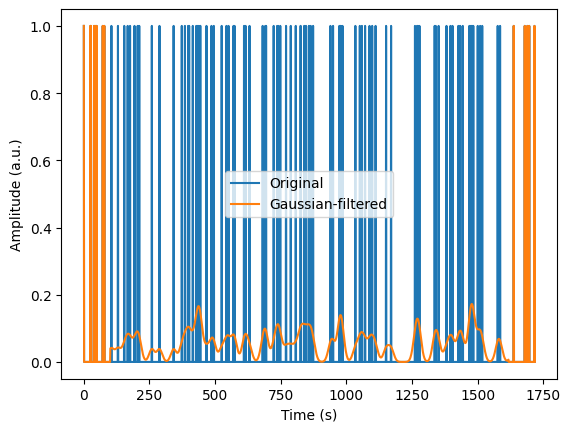

In [5]:
### Generate time series of random spikes

# Number of spikes
n = 100  

# Inter-spike intervals (exponential distribution for bursts)
isi = np.round(np.exp(np.random.randn(n)) * 10)  # Generate random intervals

# Generate spike time series
spikets = np.zeros(int(sum(isi)))  # Initialize spike time series with zeros

# Fill in the spike time series
for i in range(n):
    spikets[int(np.sum(isi[0:i]))] = 1  # Set spike events to 1 based on the intervals

# Define Gaussian window parameters
ws = 25  # Width of the Gaussian window
k = 100  # Half-width of the window in samples
gtimes = np.arange(-k, k + 1)  # Time vector for the Gaussian window

# Generate the Gaussian window
gausws = np.exp(-(4 * np.log(2) * gtimes**2) / ws**2)  # Create Gaussian window
gausws = gausws / sum(gausws)  # Normalize the Gaussian window to unit energy

# Apply Gaussian smoothing to the spike time series
filterSigGS = copy.deepcopy(spikets)  # Create a copy of the original spike series

# Apply the Gaussian filter using the defined window
for i in range(k + 1, len(spikets) - k):
    filterSigGS[i] = np.sum(spikets[i - k:i + k + 1] * gausws)  # Weighted sum using Gaussian window

# Plotting the original and Gaussian-filtered spike series
plt.plot(spikets, label='Original')  # Plot original spike series
plt.plot(filterSigGS, label='Gaussian-filtered')  # Plot Gaussian-filtered spike series

# Label the axes
plt.xlabel('Time (s)')  # Label for the x-axis
plt.ylabel('Amplitude (a.u.)')  # Label for the y-axis
plt.legend()  # Show legend
plt.show()  # Display the plot


## TKEO(Teager-Kaiser energy-tracking operator)

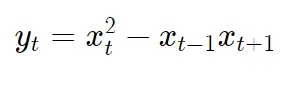

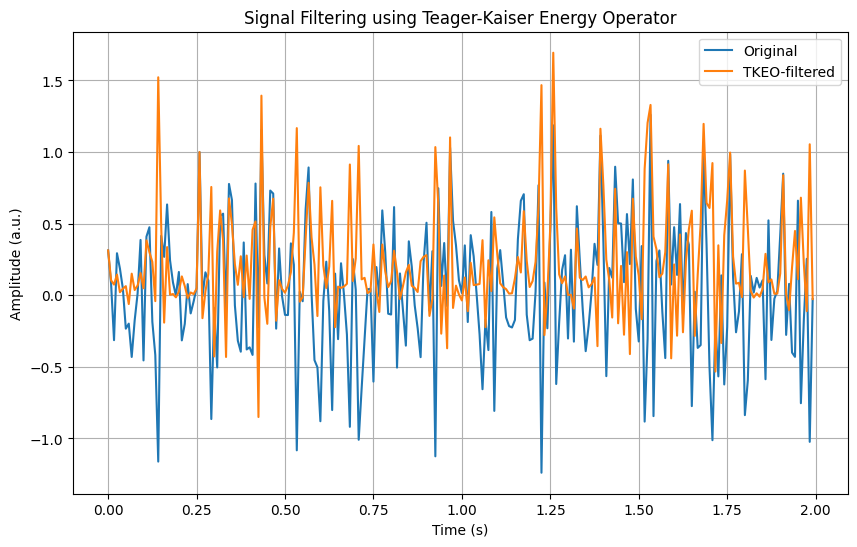

In [6]:
# Sampling rate and time vector
sRate = 120  # Sampling rate in Hz
time = np.arange(0, 2, 1/sRate)  # Time vector from 0 to 2 seconds
n = len(time)  # Length of the time vector

# Generate a low-frequency sine wave signal
freq = 1  # Frequency of the sine wave in Hz
amplitude = 0.1  # Amplitude of the sine wave
lowFreqSig = amplitude * np.sin(2 * np.pi * freq * time)  # Sine wave signal

# Generate noise
noiseAmp = 0.5  # Amplitude of the noise
noise = noiseAmp * np.random.randn(n)  # Create Gaussian noise

# Combine the low-frequency signal and noise to create the final signal
signal = lowFreqSig + noise

# Applying the Teager-Kaiser Energy Operator (TKEO) for filtering
filterTKEO = copy.deepcopy(signal)  # Create a copy of the original signal for filtering

# Apply TKEO to the signal
for i in range(1, n - 1):  # Loop over the signal, avoiding the first and last samples
    filterTKEO[i] = signal[i]**2 - signal[i - 1] * signal[i + 1]  # TKEO formula

# Plotting the original and TKEO-filtered signals
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(time, signal, label='Original')  # Plot original noisy signal
plt.plot(time, filterTKEO, label='TKEO-filtered')  # Plot TKEO-filtered signal

# Label the axes
plt.xlabel('Time (s)')  # Label for the x-axis
plt.ylabel('Amplitude (a.u.)')  # Label for the y-axis
plt.legend()  # Show legend
plt.title("Signal Filtering using Teager-Kaiser Energy Operator")  # Title for the plot
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

## Median filter to remove spike

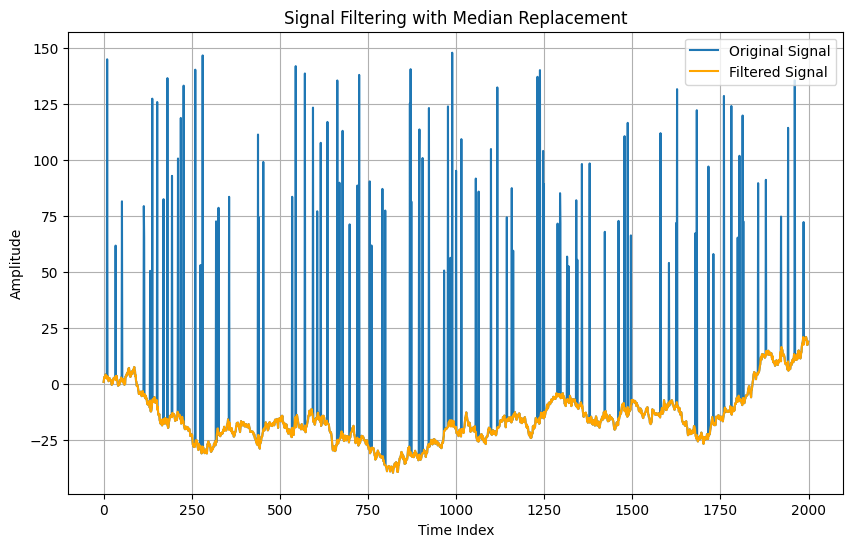

In [7]:
### Generate a random walk signal

n = 2000  # Number of points in the signal
signal = np.cumsum(np.random.randn(n))  # Cumulative sum to create a random walk signal

# Proportion of time points to replace with noise
propnoise = 0.05  # 5% of the signal will be replaced with noise

# Find noise points
noisepnts = np.random.permutation(n)  # Randomly permute indices
noisepnts = noisepnts[0:int(n * propnoise)]  # Select the first 5% of points

# Replace selected points with random noise
signal[noisepnts] = 50 + np.random.rand(len(noisepnts)) * 100  # Add noise values in the range [50, 150]

# Define threshold for filtering
threshold = 40

# Find data values above the threshold
suprathresh = np.where(signal > threshold)[0]  # Indices of points above the threshold

# Initialize the filtered signal as a copy of the original signal
filtsig = copy.deepcopy(signal)

# Loop through suprathreshold points to replace them with median of surrounding values
k = 20  # Half-window size; actual window size is (2*k + 1)
for ti in range(len(suprathresh)):
    # Lower and upper bounds for the median calculation
    lowbnd = np.max((0, suprathresh[ti] - k))  # Ensure lower bound is not less than 0
    uppbnd = np.min((suprathresh[ti] + k + 1, n))  # Ensure upper bound does not exceed n

    # Compute median of surrounding points and replace the suprathreshold point
    filtsig[suprathresh[ti]] = np.median(signal[lowbnd:uppbnd])  # Replace with median

# Plot original and filtered signals
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(range(0, n), signal, label='Original Signal')  # Plot original signal
plt.plot(range(0, n), filtsig, label='Filtered Signal', color='orange')  # Plot filtered signal

# Label the axes
plt.xlabel('Time Index')  # Label for the x-axis
plt.ylabel('Amplitude')  # Label for the y-axis
plt.legend()  # Show legend
plt.title("Signal Filtering with Median Replacement")  # Title for the plot
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

## Remove Linear Trend

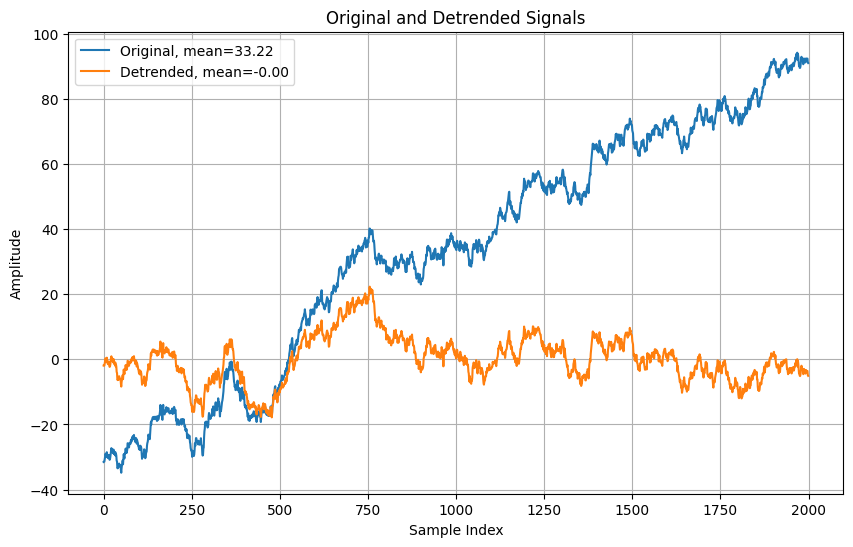

In [8]:
### Create a signal with a linear trend imposed

n = 2000  # Number of points in the signal
signal = np.cumsum(np.random.randn(n)) + np.linspace(-30, 30, n)  # Random walk with a linear trend

# Linear detrending
detsignal = scipy.signal.detrend(signal)  # Remove the linear trend from the signal

# Calculate means
omean = np.mean(signal)  # Mean of the original signal
dmean = np.mean(detsignal)  # Mean of the detrended signal

# Plot original signal and detrended signal
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(range(0, n), signal, label='Original, mean={:.2f}'.format(omean))  # Plot original signal
plt.plot(range(0, n), detsignal, label='Detrended, mean={:.2f}'.format(dmean))  # Plot detrended signal

# Add legend and display the plot
plt.legend()  # Show legend
plt.title("Original and Detrended Signals")  # Title for the plot
plt.xlabel('Sample Index')  # Label for the x-axis
plt.ylabel('Amplitude')  # Label for the y-axis
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

## Remove Nonlinear Trend

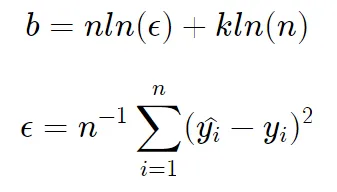

C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:20: RankWarning: Polyfit may be poorly conditioned
  yHat = np.polyval(np.polyfit(t

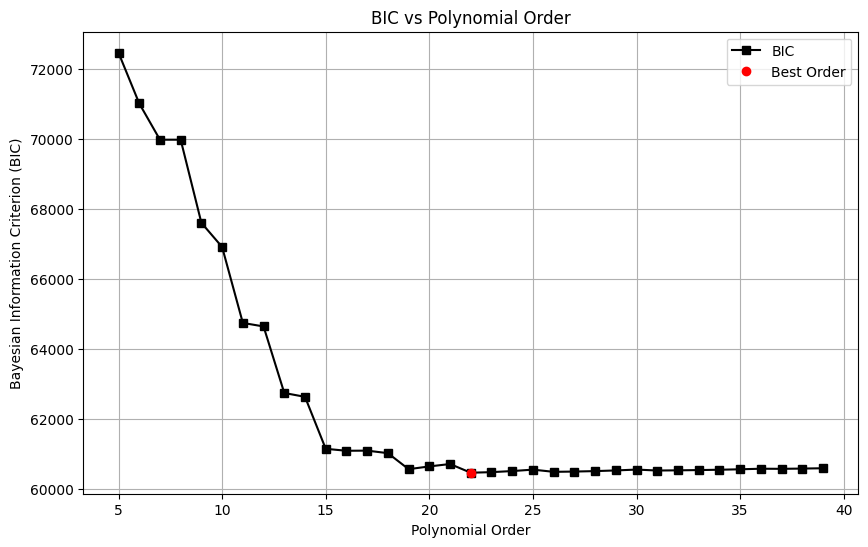

C:\Users\kerem\AppData\Local\Temp\ipykernel_2132\268866042.py:44: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(t, signal, orders[idx])


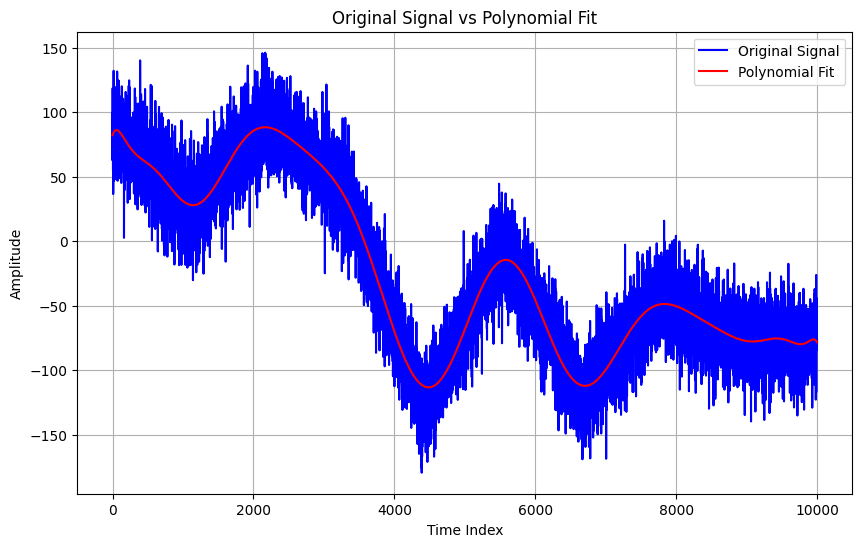

In [9]:
### Generate a signal with a slow polynomial artifact

n = 10000  # Number of data points
t = range(n)  # Time vector
k = 10  # Number of poles for random amplitudes

# Create a slow drift signal using interpolation of random amplitudes
slowdrift = np.interp(np.linspace(1, k, n), np.arange(0, k), 100 * np.random.randn(k))
signal = slowdrift + 20 * np.random.randn(n)  # Combine slow drift with noise

# Define possible polynomial orders for fitting
orders = range(5, 40)

# Initialize array for sum of squared errors (sse)
sse1 = np.zeros(len(orders))

# Loop through polynomial orders to compute sum of squared errors
for ri in range(len(orders)):
    # Compute polynomial fit to the signal
    yHat = np.polyval(np.polyfit(t, signal, orders[ri]), t)
    
    # Calculate sum of squared errors for the fit
    sse1[ri] = np.sum((yHat - signal)**2) / n

# Calculate Bayesian Information Criterion (BIC)
bic = n * np.log(sse1) + orders * np.log(n)

# Find the polynomial order with the lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# Plot the BIC for different polynomial orders
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(orders, bic, 'ks-', label='BIC')  # Plot BIC
plt.plot(orders[idx], bestP, 'ro', label='Best Order')  # Highlight best polynomial order
plt.xlabel('Polynomial Order')  # Label for the x-axis
plt.ylabel('Bayesian Information Criterion (BIC)')  # Label for the y-axis
plt.title('BIC vs Polynomial Order')  # Title for the plot
plt.legend()  # Show legend
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

# Fit the best polynomial to the signal
p = np.polyfit(t, signal, orders[idx])

# Evaluate the polynomial to get predicted data
yHat = np.polyval(p, t)

# Compute the residual (the cleaned signal)
residual = signal - yHat

# Now plot the original signal and the polynomial fit
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(t, signal, 'b', label='Original Signal')  # Plot original signal
plt.plot(t, yHat, 'r', label='Polynomial Fit')  # Plot polynomial fit
plt.xlabel('Time Index')  # Label for the x-axis
plt.ylabel('Amplitude')  # Label for the y-axis
plt.title('Original Signal vs Polynomial Fit')  # Title for the plot
plt.legend()  # Show legend
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

## Averaging multiple repetitions

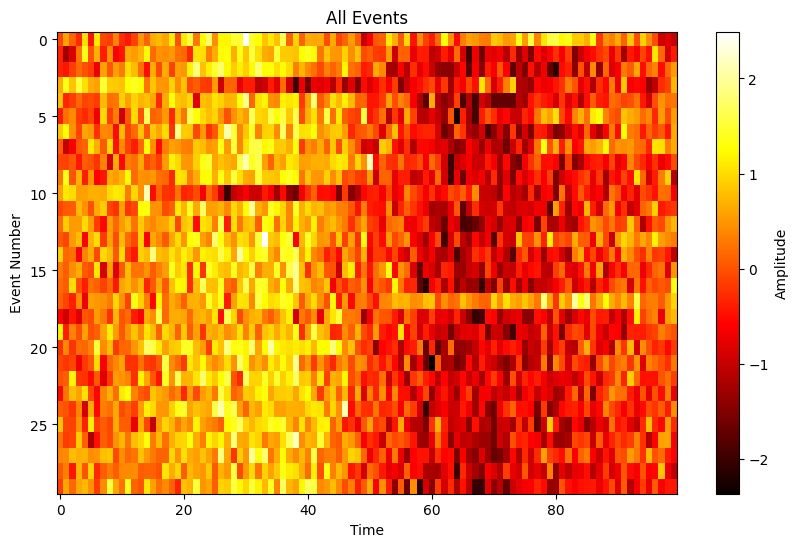

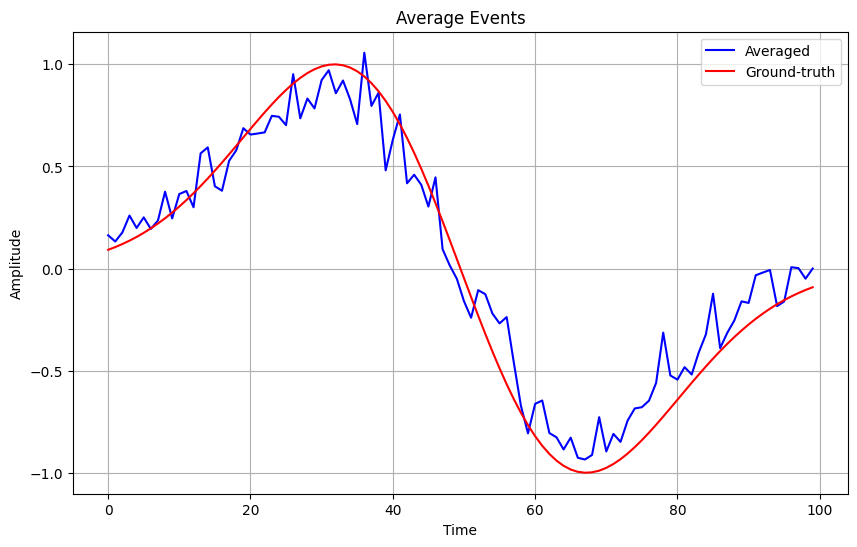

In [10]:
### Simulate data

# Create event (derivative of Gaussian)
k = 100  # Duration of event in time points
event = np.diff(np.exp(-np.linspace(-2, 2, k + 1) ** 2))  # Derivative of Gaussian
event = event / np.max(event)  # Normalize to max=1

# Event onset times
Nevents = 30  # Number of events to generate
onsettimes = np.random.permutation(10000 - k)  # Randomly permute possible onset times
onsettimes = onsettimes[0:Nevents]  # Select the first Nevents as onset times

# Put event into data
data = np.zeros(10000)  # Initialize data array with zeros
for ei in range(Nevents):
    data[onsettimes[ei]:onsettimes[ei] + k] = event  # Insert event at onset time

# Add noise
data = data + 0.5 * np.random.randn(len(data))  # Add Gaussian noise to the data

# Extract all events into a matrix
datamatrix = np.zeros((Nevents, k))  # Initialize matrix to hold events

for ei in range(Nevents):
    datamatrix[ei, :] = data[onsettimes[ei]:onsettimes[ei] + k]  # Fill matrix with event data

# Plot all events
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(datamatrix, aspect='auto', cmap='hot')  # Plot the data matrix as an image
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Event Number')  # Label for the y-axis
plt.title('All Events')  # Title for the plot
plt.colorbar(label='Amplitude')  # Colorbar to indicate amplitude
plt.show()  # Display the plot

# Plot average events
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(range(0, k), np.mean(datamatrix, axis=0), label='Averaged', color='blue')  # Plot average of events
plt.plot(range(0, k), event, label='Ground-truth', color='red')  # Plot ground-truth event
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Amplitude')  # Label for the y-axis
plt.legend()  # Show legend
plt.title('Average Events')  # Title for the plot
plt.grid()  # Add grid for better readability
plt.show()  # Display the plot

## Remove artifact via least-squares template matching

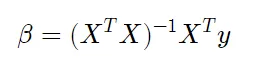 
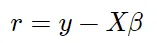

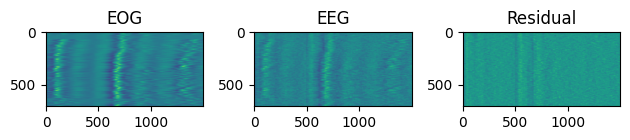

In [11]:
# Load dataset
matdat = sio.loadmat('templateProjection.mat')  # Load the .mat file
EEGdat = matdat['EEGdat']  # Extract EEG data
eyedat = matdat['eyedat']  # Extract EOG data
timevec = matdat['timevec'][0]  # Extract time vector
MN = np.shape(EEGdat)  # Get matrix sizes (number of time points x number of trials)

# Initialize residual data
resdat = np.zeros(np.shape(EEGdat))  # Create an array for residuals of the same shape as EEG data

# Loop over trials
for triali in range(MN[1]):
    # Build the least-squares model as intercept and EOG from this trial
    X = np.column_stack((np.ones(MN[0]), eyedat[:, triali]))  # Design matrix with intercept and EOG data

    # Compute regression coefficients for EEG channel using least squares
    b = np.linalg.solve(X.T @ X, X.T @ EEGdat[:, triali])  # Solve the normal equations

    # Predicted data (EOG influence on EEG)
    yHat = X @ b  # Calculate predicted EEG data based on EOG

    # New data are the residuals after projecting out the best EOG fit
    resdat[:, triali] = EEGdat[:, triali] - yHat  # Store residuals

# Show all trials in a map
clim = [-1, 1] * 20  # Set color limits for the plots

# Plot EOG data
plt.subplot(131)  # 1 row, 3 columns, 1st subplot
plt.imshow(eyedat.T)  # Transpose for correct orientation
plt.title('EOG')  # Title for EOG plot

# Plot EEG data
plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
plt.imshow(EEGdat.T)  # Transpose for correct orientation
plt.title('EEG')  # Title for EEG plot

# Plot residual data
plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
plt.imshow(resdat.T)  # Transpose for correct orientation
plt.title('Residual')  # Title for residual plot

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()  # Display the plots